In [16]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("Coded_Segments.csv")
print(df.head())

               Dokumentname         Code  Anfang  Ende  \
0  reflection_assignment_P1      Level 1       1     1   
1  reflection_assignment_P1      Level 1       1     1   
2  reflection_assignment_P1      Level 1       1     1   
3  reflection_assignment_P1  Level 2 (a)       1     1   
4  reflection_assignment_P1  Level 2 (a)       1     1   

                                             Segment  
0  I am a newbie in data science (DS). On the one...  
1  However, the handling of data in basic cogniti...  
2  The HCDS course was largely aimed at a critica...  
3  Among these topics, some messages particularly...  
4  First of all, I became aware of the importance...  


In [4]:
df['Code'].value_counts()

Code
Level 3        90
Level 1        69
Level 2 (b)    41
Level 2 (a)    31
Level 4         6
Name: count, dtype: int64

(array([69.,  0., 31.,  0.,  0., 41.,  0., 90.,  0.,  6.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

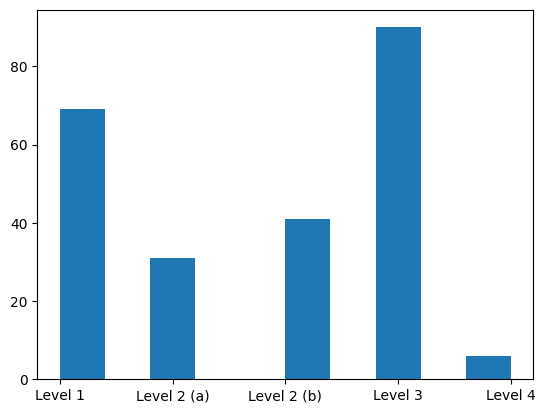

In [5]:
plt.hist(sorted(df['Code']))

In [7]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['Code'])

    # handle imbalanced dataset
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(df[['Segment']], df['class'])
    df_resampled = pd.DataFrame({'Segment': X_resampled['Segment'], 'class': y_resampled})

    print(f"Original dataset shape: {df.shape}")
    print(f"Resampled dataset shape: {df_resampled.shape}")

    return df_resampled, le

In [8]:
df_resampled, label_encoder = preprocess_data(df)
print(df_resampled)

Original dataset shape: (237, 6)
Resampled dataset shape: (450, 2)
                                               Segment  class
0    I am a newbie in data science (DS). On the one...      0
1    However, the handling of data in basic cogniti...      0
2    The HCDS course was largely aimed at a critica...      0
3    Among these topics, some messages particularly...      1
4    First of all, I became aware of the importance...      1
..                                                 ...    ...
445  The first concern, to begin  with, is to check...      4
446  The first concern, to begin  with, is to check...      4
447  Social nuances have shown how important it is ...      4
448  It also made me realise the high personal resp...      4
449  As an when my experience grew, I started to un...      4

[450 rows x 2 columns]


In [9]:
df_resampled['class'].value_counts()

class
0    90
1    90
4    90
2    90
3    90
Name: count, dtype: int64

(array([90.,  0., 90.,  0.,  0., 90.,  0., 90.,  0., 90.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

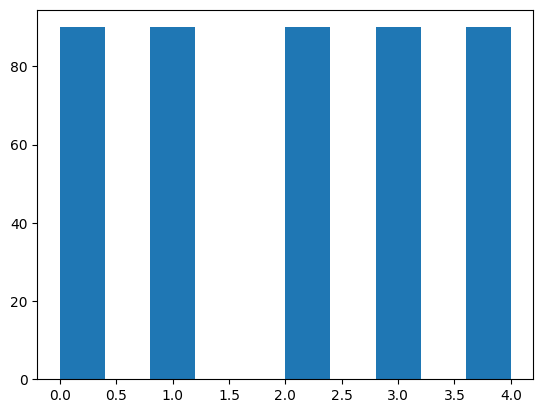

In [10]:
plt.hist(sorted(df_resampled['class']))

Validation Set Results:
Accuracy: 0.88
Cohen's Kappa: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        13
           1       0.93      0.93      0.93        14
           2       0.92      0.85      0.88        13
           3       0.89      0.62      0.73        13
           4       1.00      1.00      1.00        14

    accuracy                           0.88        67
   macro avg       0.89      0.88      0.87        67
weighted avg       0.89      0.88      0.88        67



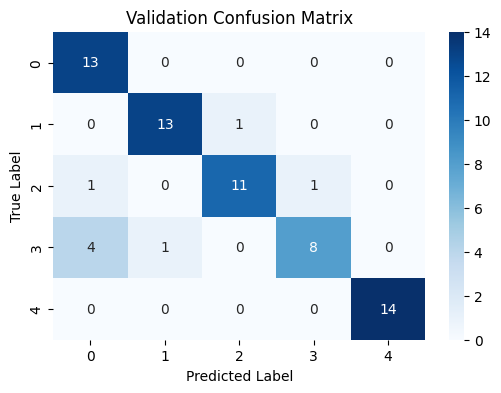


Test Set Results:
Accuracy: 0.87
Cohen's Kappa: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        14
           1       1.00      0.92      0.96        13
           2       0.86      0.86      0.86        14
           3       0.71      0.71      0.71        14
           4       1.00      1.00      1.00        13

    accuracy                           0.87        68
   macro avg       0.87      0.87      0.87        68
weighted avg       0.87      0.87      0.87        68



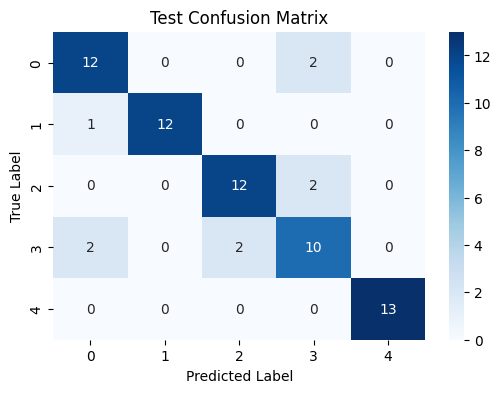

In [12]:
# Preprocessing
# Split into training, validation and test sets
train_df, temp_df = train_test_split(df_resampled, test_size=0.3, stratify=df_resampled['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

# Extract text and labels
X_train, y_train = train_df['Segment'], train_df['class']
X_val, y_val = val_df['Segment'], val_df['class']
X_test, y_test = test_df['Segment'], test_df['class']

# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Evaluate on validation and test sets
rf_y_val_pred = rf_model.predict(X_val_tfidf)
rf_y_test_pred = rf_model.predict(X_test_tfidf)

# Metrics for validation set
rf_val_accuracy = accuracy_score(y_val, rf_y_val_pred)
rf_val_class_report = classification_report(y_val, rf_y_val_pred, zero_division=0)
rf_val_cohen_kappa = cohen_kappa_score(y_val, rf_y_val_pred)
rf_val_cm = confusion_matrix(y_val, rf_y_val_pred)

# Metrics for test set
rf_test_accuracy = accuracy_score(y_test, rf_y_test_pred)
rf_test_class_report = classification_report(y_test, rf_y_test_pred, zero_division=0)
rf_test_cohen_kappa = cohen_kappa_score(y_test, rf_y_test_pred)
rf_test_cm = confusion_matrix(y_test, rf_y_test_pred)

# Print results
print("Validation Set Results:")
print(f"Accuracy: {rf_val_accuracy:.2f}")
print(f"Cohen's Kappa: {rf_val_cohen_kappa:.2f}")
print("Classification Report:")
print(rf_val_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(rf_val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_val)), yticklabels=sorted(set(y_val)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()

print("\nTest Set Results:")
print(f"Accuracy: {rf_test_accuracy:.2f}")
print(f"Cohen's Kappa: {rf_test_cohen_kappa:.2f}")
print("Classification Report:")
print(rf_test_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(rf_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")
plt.show()

In [19]:
# Get the feature names (words) from the TF-IDF vectorizer
feature_names = np.array(vectorizer.get_feature_names_out())

# Compute permutation importance
perm_importance = permutation_importance(rf_model, X_val_tfidf.toarray(), y_val, n_repeats=10, random_state=42)

# Get the top 10 features for each class
top10_idx = np.argsort(perm_importance.importances_mean)[-10:][::-1]

print("\n🔍 Top 10 Important Features (Using Permutation Importance):")
for idx in top10_idx:
    print(f"{feature_names[idx]}: {perm_importance.importances_mean[idx]:.4f}")


🔍 Top 10 Important Features (Using Permutation Importance):
not: 0.0328
it: 0.0194
would: 0.0179
people: 0.0149
in: 0.0149
but: 0.0134
practice: 0.0134
the: 0.0134
as: 0.0104
with: 0.0075


In [20]:
# Get the global feature importance
rf_feature_importance = rf_model.feature_importances_

# Get the indices of the top 10 most important features (globally)
top10_idx = np.argsort(rf_feature_importance)[-10:][::-1]

print("\n🔍 Top 10 Important Features (Global for All Classes):")
for idx in top10_idx:
    print(f"{feature_names[idx]}: {rf_feature_importance[idx]:.4f}")


🔍 Top 10 Important Features (Global for All Classes):
of: 0.0129
not: 0.0127
to: 0.0113
that: 0.0104
would: 0.0089
be: 0.0088
in: 0.0088
as: 0.0087
me: 0.0086
the: 0.0083
